<center>
<h1 style="color:red; font-size:70px;"> Esercitazione 5</h1>

In [41]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from hyperopt.pyll.stochastic import sample
from hyperopt import tpe, hp, fmin, Trials, rand
from tensorflow.keras import layers, activations

from keras.layers import Input, Flatten, Dense

<h1 style="color: blue; font-size:50px;"> Esercizio 1 - Ottimizzazione Bayesana</h1>

L’ottimizzazione bayesiana è una tecnica di ottimizzazione usata per trovare il massimo (o minimo) di una funzione obiettivo costosa da valutare e senza una forma analitica nota, cioè una black-box function. Per svolgere questo esercizio verrà utilizzata la libreria **Hyperopt**, pensata per l'ottimizzazione automatica di funzioni.

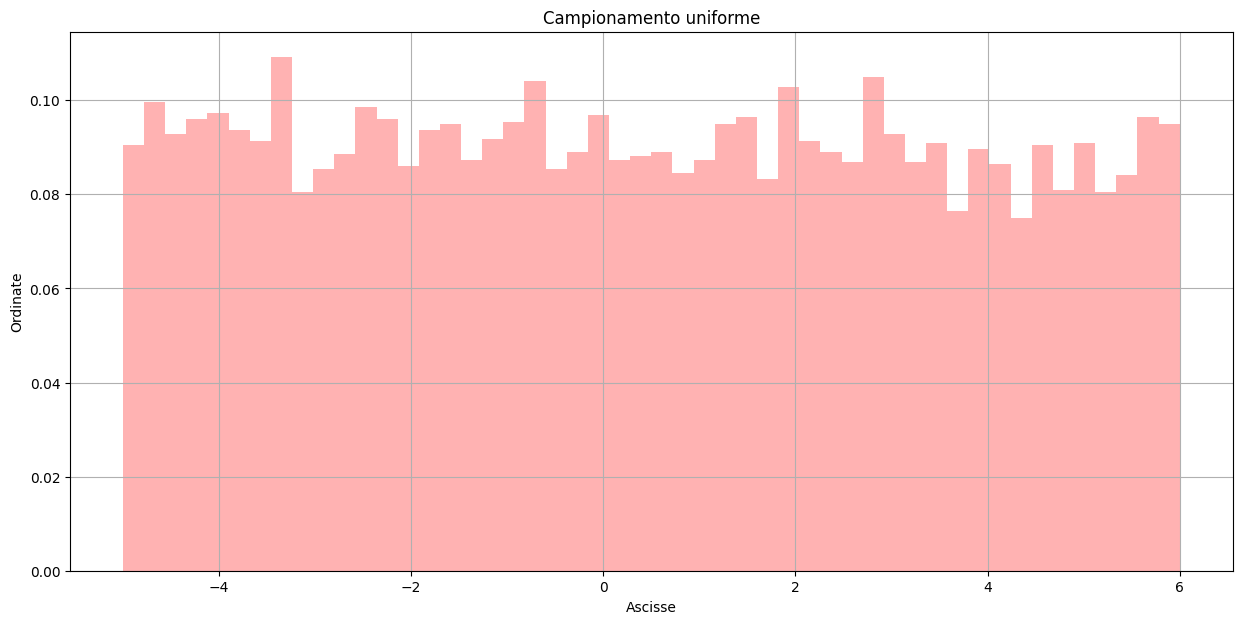

100%|██████████| 2000/2000 [01:20<00:00, 24.90trial/s, best loss: -219.80120228941115]
Miglior valore dell'iperparametro:  4.878246952160149


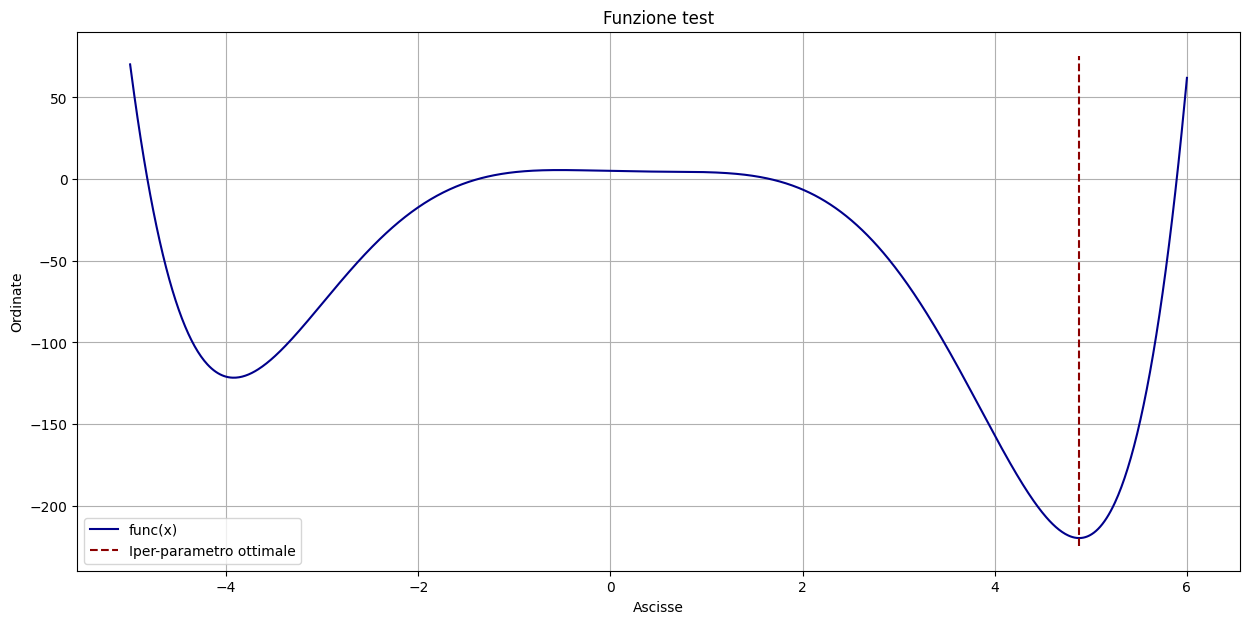

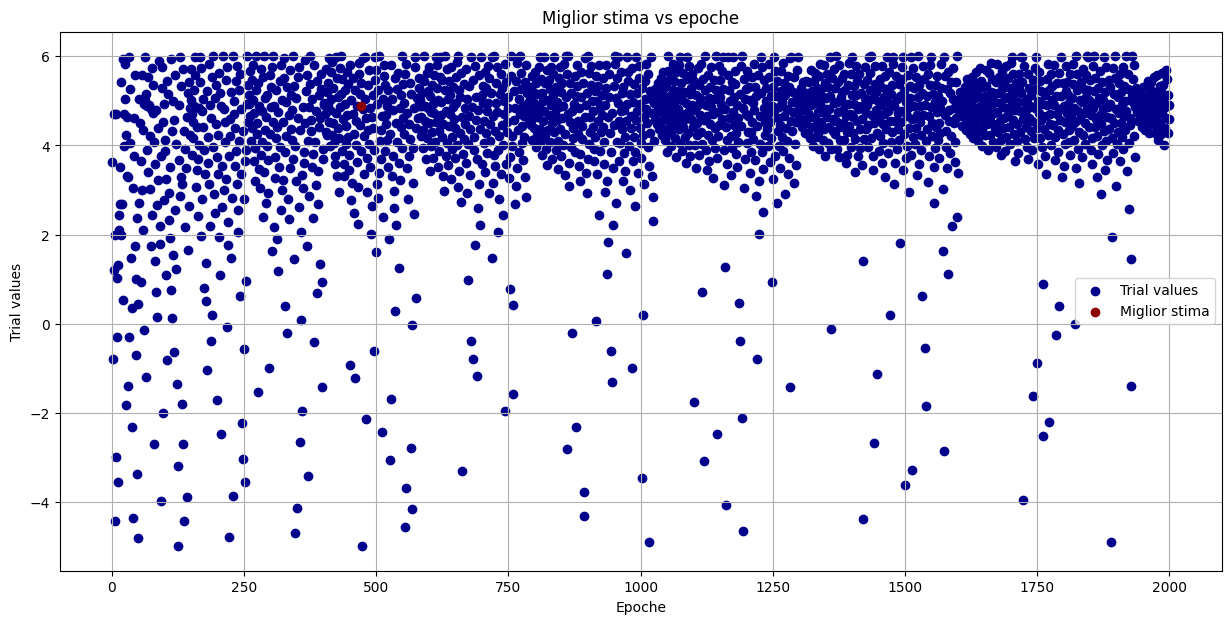

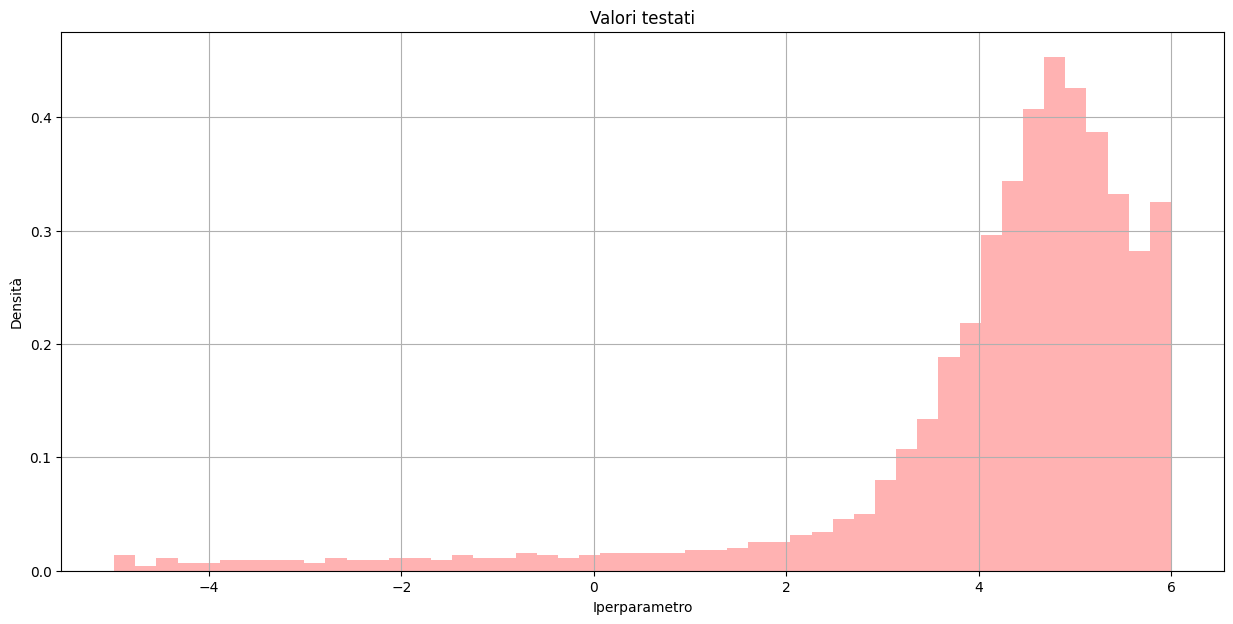

In [29]:
def func(x):
    # Polinomio f(x) = 0.05 * (x^6 - 2x^5 - 28x^4 + 28x^3 + 12x^2 - 26x + 100)
    p = np.poly1d([1, -2, -28, 28, 12, -26, 100])
    return p(x) * 0.05

def plotF(x, minV):
    # Funzione per plottare target

    y = func(x)         # Calcolo funzione
    fig = plt.figure(figsize = (15, 7))
    plt.plot(x, y, color = 'darkblue', label = "func(x)")
    plt.plot(np.array([minV, minV]), np.array([min(y)-5, max(y)+5]), color = 'darkred', linestyle = '--', label = "Iper-parametro ottimale")
    plt.title("Funzione test")
    plt.ylabel("Ordinate")
    plt.xlabel("Ascisse")
    plt.legend(loc = 'best')
    plt.grid(True)
    plt.show()

def plotUnif(x, nbins):
    # Funzione per plottare campionamento uniforme
    fig = plt.figure(figsize = (15, 7))
    plt.hist(x, bins = nbins, range = (min(x), max(x)), density = True, color = (1, 0, 0, 0.3))
    plt.title("Campionamento uniforme")
    plt.ylabel("Ordinate")
    plt.xlabel("Ascisse")
    plt.grid(True)
    plt.show()


def plotHypTr(trials, minV):
    # Funzione per plottare trials vs epoche
    fig = plt.figure(figsize = (15, 7))
    plt.scatter(np.linspace(1, 2000, 2000), np.array(trials.vals['x']), color = 'darkblue', label = 'Trial values')
    plt.scatter(np.array([np.argmin(np.array(trials.vals['x']))]), np.array(minV['x']), color = 'darkred', label = 'Miglior stima')

    plt.title("Miglior stima vs epoche")
    plt.ylabel("Trial values")
    plt.xlabel("Epoche")

    plt.legend(loc = 'best')
    plt.grid(True)
    plt.show()


def plotSearch(trials, nbins):
    # Funzione per plottare istogramma ricerca minimo
    fig = plt.figure(figsize = (15, 7))
    plt.hist(np.array(trials.vals['x']), bins = nbins, color = (1, 0, 0, 0.3), density=True)

    plt.title("Valori testati")
    plt.xlabel("Iperparametro")
    plt.ylabel("Densità")

    plt.grid(True)
    plt.show()


# Definiamo ora un dominio di ricerca uniforme utilizzando hyperopt
# Facciamo sampling di questo dominio e facciamo un istogramma
space = hp.uniform('x', -5, 6)
plotUnif([sample(space) for _ in range(10000)], 50)


# Procediamo con la minimizzazione della funzione obiettivo, ossia func(x), utilizzando il modello TPE. Le 
# valutazioni della funzione stessa sono 2000. Utilizzo Trials per tenere memoria dell'evoluzione dei vari 
# parametri nelle fasi di allenamento del modello
trials = Trials()
minV = fmin(
    fn=func,                # Funzione obiettivo da ottimizzare
    space=space,            # Spazio dell'iperparametro, in cui sarà cercato il valore ottimale
    algo=tpe.suggest,       # Algoritmo di ottimizzazione
    max_evals=2000,         # Tentativi di ottimizzazione della funzione
    trials = trials         # Memorizzazione fasi ottimizzazione
)
print("Miglior valore dell'iperparametro: ", minV['x'])


# Valuto funzione polinomiale su un intervallo di punti equispaziati fra [-5, 6]
# Evidenzio come la previsione dell'ottimizzazione coincida effettivamente con il minimo della funzione
x = np.linspace(-5, 6, 1000)
plotF(x, minV['x'])


# Stampo ora scatterplot e istogramma per analisi più dettagliate su metodologia ricerca minimo
plotHypTr(trials, minV)
plotSearch(trials, 50)

  0%|          | 0/2000 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 2000/2000 [00:26<00:00, 75.19trial/s, best loss: -219.79926707538618] 
Miglior valore dell'iperparametro:  4.881990936772045


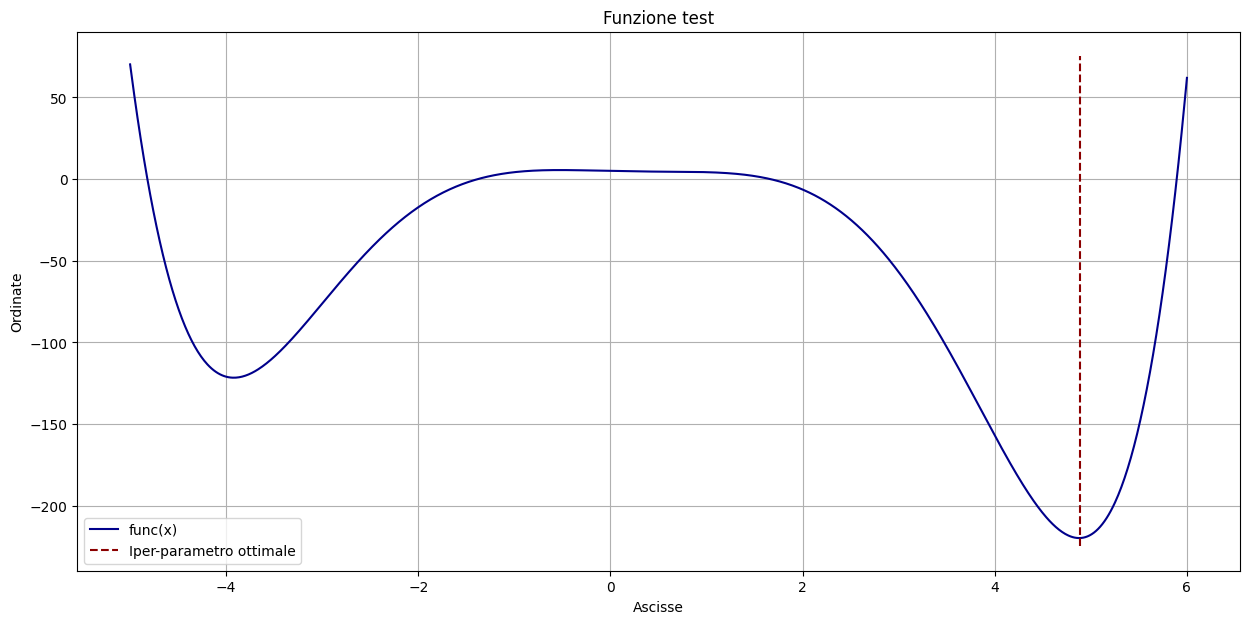

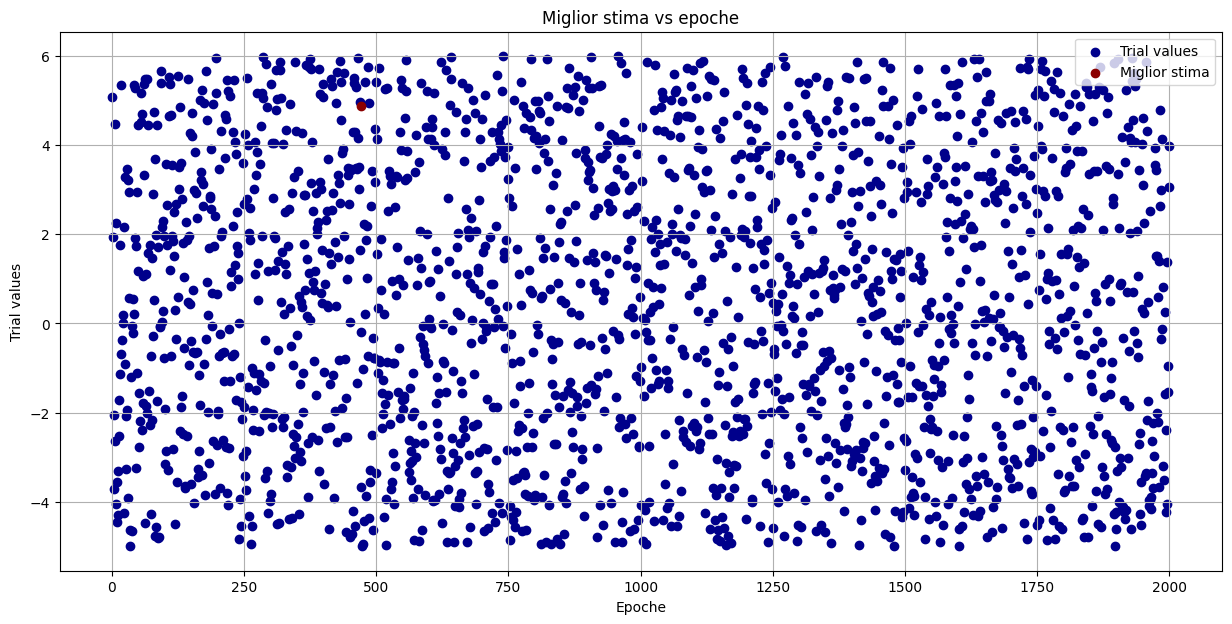

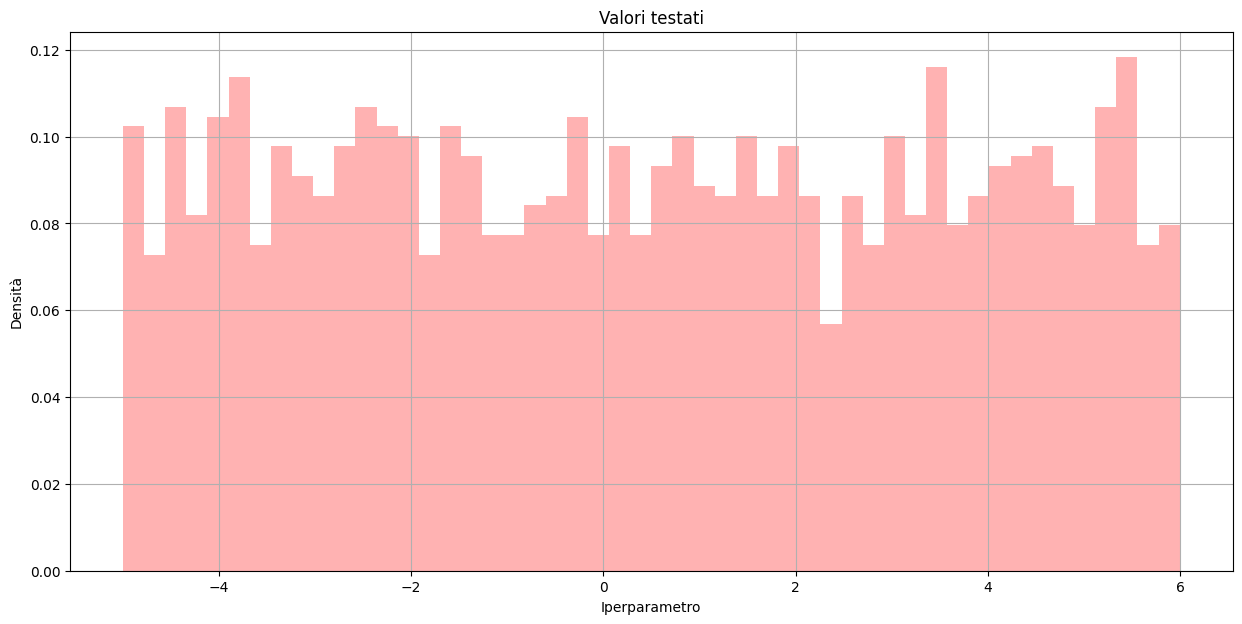

In [30]:
# Rifaccio quanto ho appena fatto sopra, ma utilizzando un algoritmo di ricerca stocastico
def func(x):
    # Polinomio f(x) = 0.05 * (x^6 - 2x^5 - 28x^4 + 28x^3 + 12x^2 - 26x + 100)
    p = np.poly1d([1, -2, -28, 28, 12, -26, 100])
    return p(x) * 0.05

def plotF(x, minV):
    # Funzione per plottare target

    y = func(x)         # Calcolo funzione
    fig = plt.figure(figsize = (15, 7))
    plt.plot(x, y, color = 'darkblue', label = "func(x)")
    plt.plot(np.array([minV, minV]), np.array([min(y)-5, max(y)+5]), color = 'darkred', linestyle = '--', label = "Iper-parametro ottimale")
    plt.title("Funzione test")
    plt.ylabel("Ordinate")
    plt.xlabel("Ascisse")
    plt.legend(loc = 'best')
    plt.grid(True)
    plt.show()

def plotUnif(x, nbins):
    # Funzione per plottare campionamento uniforme
    fig = plt.figure(figsize = (15, 7))
    plt.hist(x, bins = nbins, range = (min(x), max(x)), density = True, color = (1, 0, 0, 0.3))
    plt.title("Campionamento uniforme")
    plt.ylabel("Ordinate")
    plt.xlabel("Ascisse")
    plt.grid(True)
    plt.show()


def plotHypTr(trials, minV):
    # Funzione per plottare trials vs epoche
    fig = plt.figure(figsize = (15, 7))
    plt.scatter(np.linspace(1, 2000, 2000), np.array(trials.vals['x']), color = 'darkblue', label = 'Trial values')
    plt.scatter(np.array([np.argmin(np.array(trials.vals['x']))]), np.array(minV['x']), color = 'darkred', label = 'Miglior stima')

    plt.title("Miglior stima vs epoche")
    plt.ylabel("Trial values")
    plt.xlabel("Epoche")

    plt.legend(loc = 'best')
    plt.grid(True)
    plt.show()


def plotSearch(trials, nbins):
    # Funzione per plottare istogramma ricerca minimo
    fig = plt.figure(figsize = (15, 7))
    plt.hist(np.array(trials.vals['x']), bins = nbins, color = (1, 0, 0, 0.3), density=True)

    plt.title("Valori testati")
    plt.xlabel("Iperparametro")
    plt.ylabel("Densità")

    plt.grid(True)
    plt.show()


# Procediamo con la minimizzazione della funzione obiettivo, ossia func(x), utilizzando algoritmo stocastico. Le 
# valutazioni della funzione stessa sono 2000. Utilizzo Trials per tenere memoria dell'evoluzione dei vari 
# parametri nelle fasi di allenamento del modello
trials = Trials()
minV = fmin(
    fn=func,                # Funzione obiettivo da ottimizzare
    space=space,            # Spazio dell'iperparametro, in cui sarà cercato il valore ottimale
    algo=rand.suggest,      # Algoritmo di ottimizzazione stocastico
    max_evals=2000,         # Tentativi di ottimizzazione della funzione
    trials = trials         # Memorizzazione fasi ottimizzazione
)
print("Miglior valore dell'iperparametro: ", minV['x'])


# Valuto funzione polinomiale su un intervallo di punti equispaziati fra [-5, 6]
# Evidenzio come la previsione dell'ottimizzazione coincida effettivamente con il minimo della funzione
x = np.linspace(-5, 6, 1000)
plotF(x, minV['x'])


# Stampo ora scatterplot e istogramma per analisi più dettagliate su metodologia ricerca minimo
plotHypTr(trials, minV)
plotSearch(trials, 50)

<h1 style="color: blue; font-size:50px;"> Esercizio 2 - Hyperparameter scan</h1>

Dimensioni del training set: (60000, 28, 28)
Dimensioni del validation set: (10000, 28, 28)


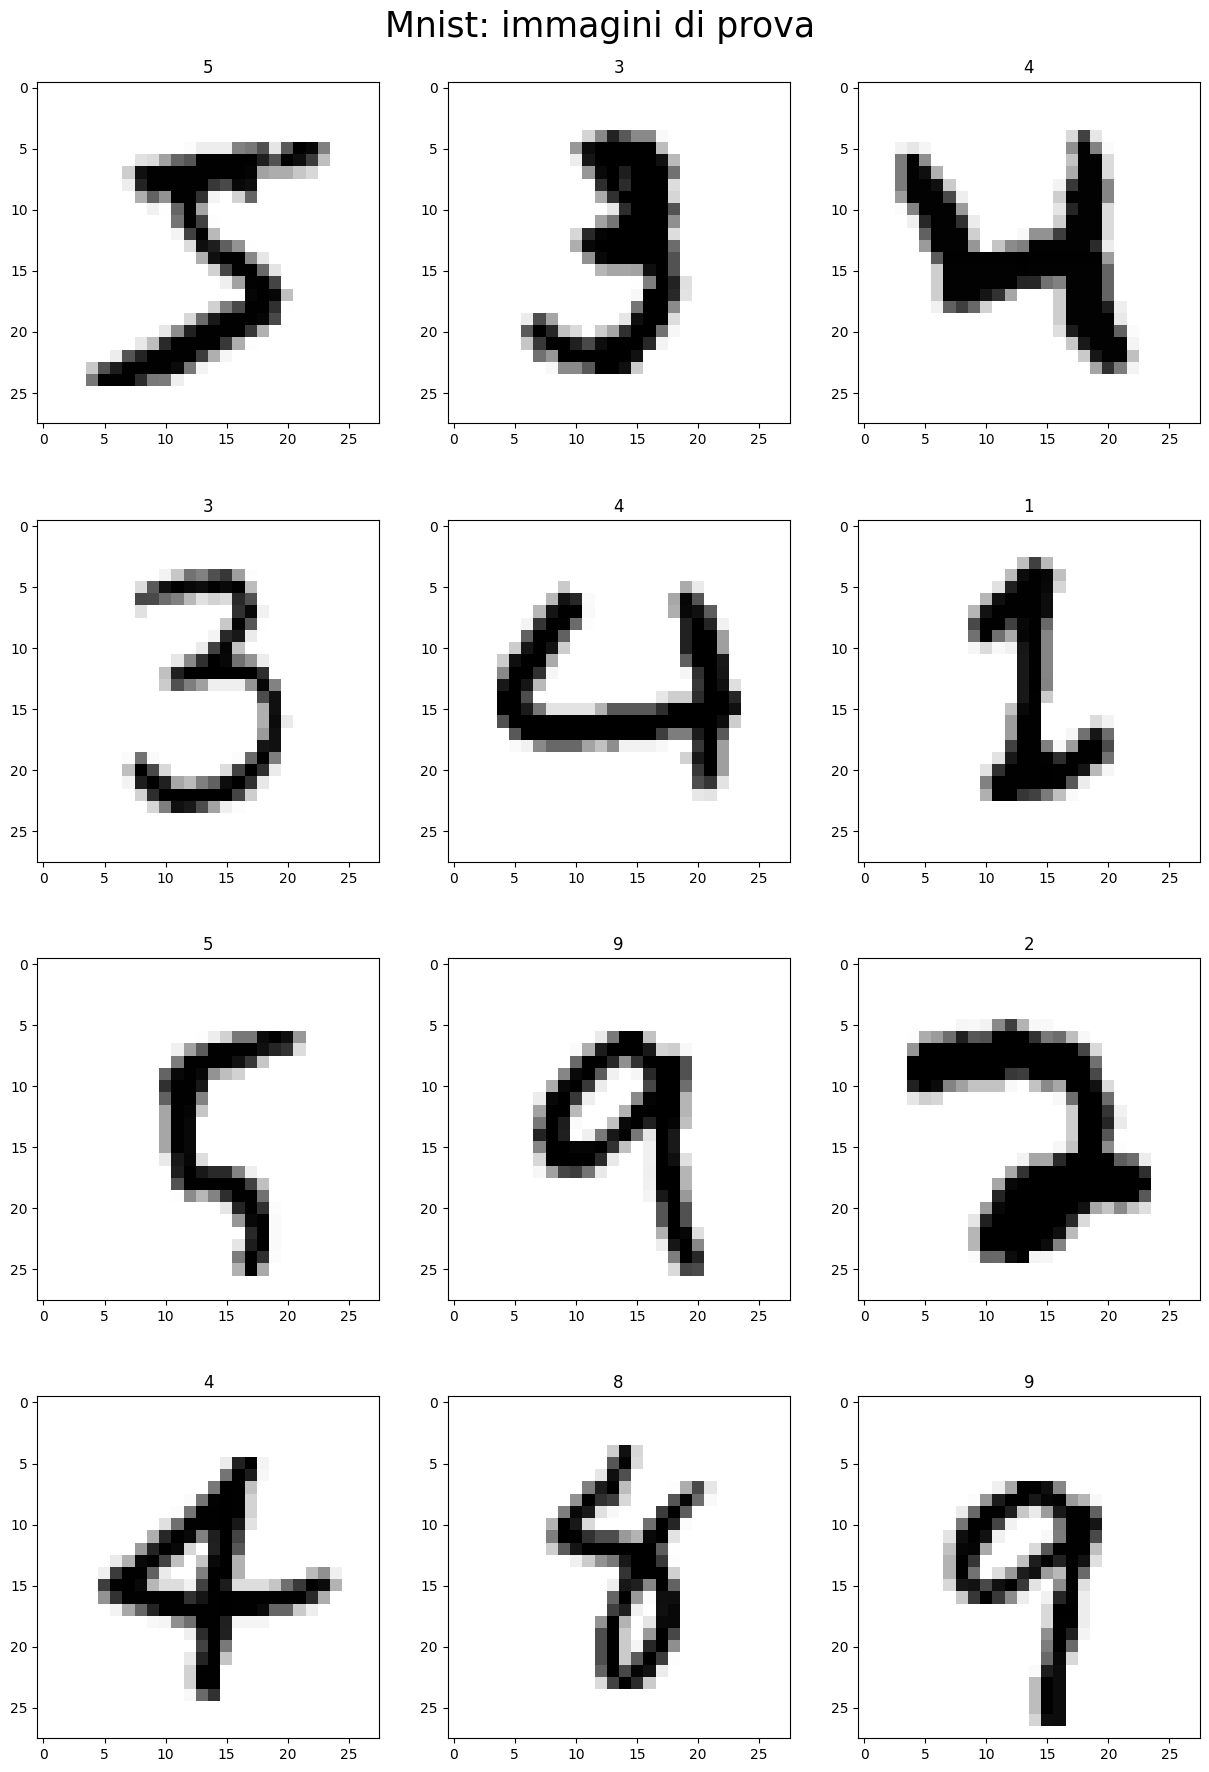

Epoch 1/5


2025-06-24 18:33:31.002749: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 31s 15ms/step - accuracy: 0.8720 - loss: 0.4453 - val_accuracy: 0.9572 - val_loss: 0.1391
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 29s 16ms/step - accuracy: 0.9637 - loss: 0.1239 - val_accuracy: 0.9691 - val_loss: 0.0980
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.9751 - loss: 0.0849 - val_accuracy: 0.9728 - val_loss: 0.0868
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.9832 - loss: 0.0577 - val_accuracy: 0.9751 - val_loss: 0.0814
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.9869 - loss: 0.0431 - val_accuracy: 0.9774 - val_loss: 0.0794
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━

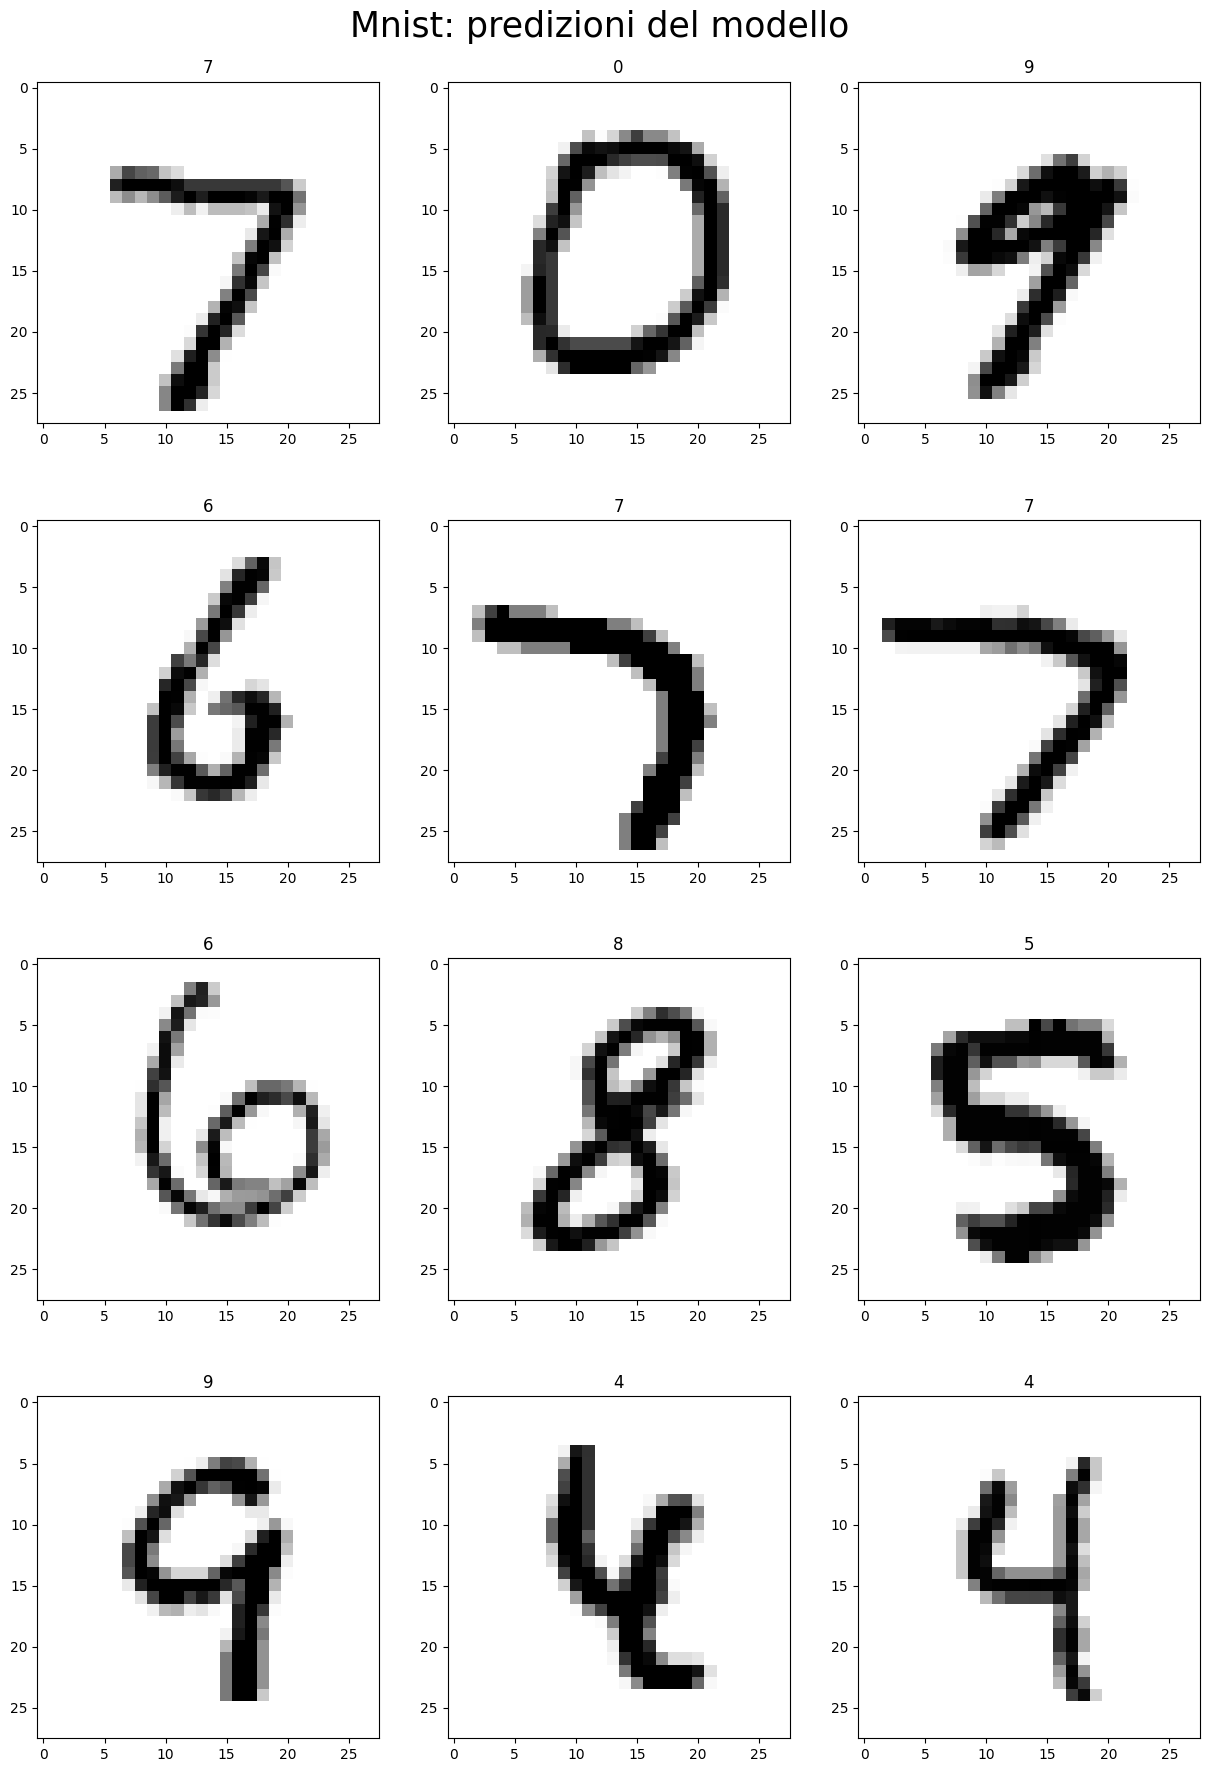

In [45]:
def printImg(img, label, title):
    # Funzione per stampa immagini di prova
    fig, ax = plt.subplots(4, 3, figsize = (15, 20))
    for i in range(0, 4):
        for j in range(0, 3):
            ax[i][j].imshow(img[50*i+10*j], cmap = 'binary')
            ax[i][j].set_title(str(label[50*i+10*j]))

    fig.suptitle(title, fontsize = 25)
    plt.subplots_adjust(top=0.95)
    plt.show()


def printPred(model, img, title):
    # Funzione per stampa predizioni
    fig, ax = plt.subplots(4, 3, figsize = (15, 20))
    for i in range(0, 4):
        for j in range(0, 3):
            ax[i][j].imshow(img[50*i+10*j], cmap = 'binary')
            ax[i][j].set_title(str(np.argmax(model.predict(np.expand_dims(img[50*i + 10*j], axis=0)))))

    fig.suptitle(title, fontsize = 25)
    plt.subplots_adjust(top=0.95)
    plt.show()


def buildMod(nlayers, nnodes):
    # Funzione per creare rete neurale. Come prima cosa controllo se 
    # l'input è adeguato (per ogni layer sto specificando correttamente il 
    # numero di nodi che lo costituiscono)
    if nlayers != len(np.array(nnodes)):
        raise ValueError("Numero di layer e numero di nodi per layer specificati non vanno bene. Occhio a lunghezza nnodes!")
    elif nlayers <= 0:
        raise ValueError("Numero di layer nascosti minore o uguale a zero!")
    else:
        model = keras.Sequential()
        
        model.add(Input(shape=(28, 28)))
        model.add(Flatten())                        # Layer di flattening
        
        for i in range(0, nlayers):
            model.add(keras.layers.Dense(nnodes[i], activation='relu'))
        model.add(keras.layers.Dense(10, activation='softmax'))
        
        return model


# Il primo step consiste nel caricare il dataset mnist, del quale valutiamo le dimensioni 
# e che normalizziamo in modo tale da avere pixel al più unitari
from keras.datasets import mnist
(imTr, labTr), (imVal, labVal) = mnist.load_data()

#Studio dimensioni
print("Dimensioni del training set:", imTr.shape)
print("Dimensioni del validation set:", imVal.shape)

# Normalizzazione immagini (e stampa immagini prova)
imVal = imVal/imVal.max()
imTr = imTr/imTr.max()
printImg(imTr, labTr, "Mnist: immagini di prova")


# Creazione del modello, che presenta un numero di layer nascosti maggiore o uguale ad uno, 
# e numero di nodi per layer specificati dall'utente in fase di inzializzazione dello stesso
model = buildMod(1, [128])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(imTr, labTr, epochs = 5, validation_data=(imVal, labVal)) 
printPred(model, imVal, "Mnist: predizioni del modello")